In [2]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import networkx as nx
import jieba
from jieba import posseg as pseg
import matplotlib.pyplot as plt
%matplotlib inline
import pypinyin as pypy
from node2vec import Node2Vec
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import torch
import torch.nn as nn
from  torch.nn import functional as F
import torch.optim as optim

# below is a context graph, that represents words that are adjencent to each other with count as weight

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.619 seconds.
Prefix dict has been built succesfully.


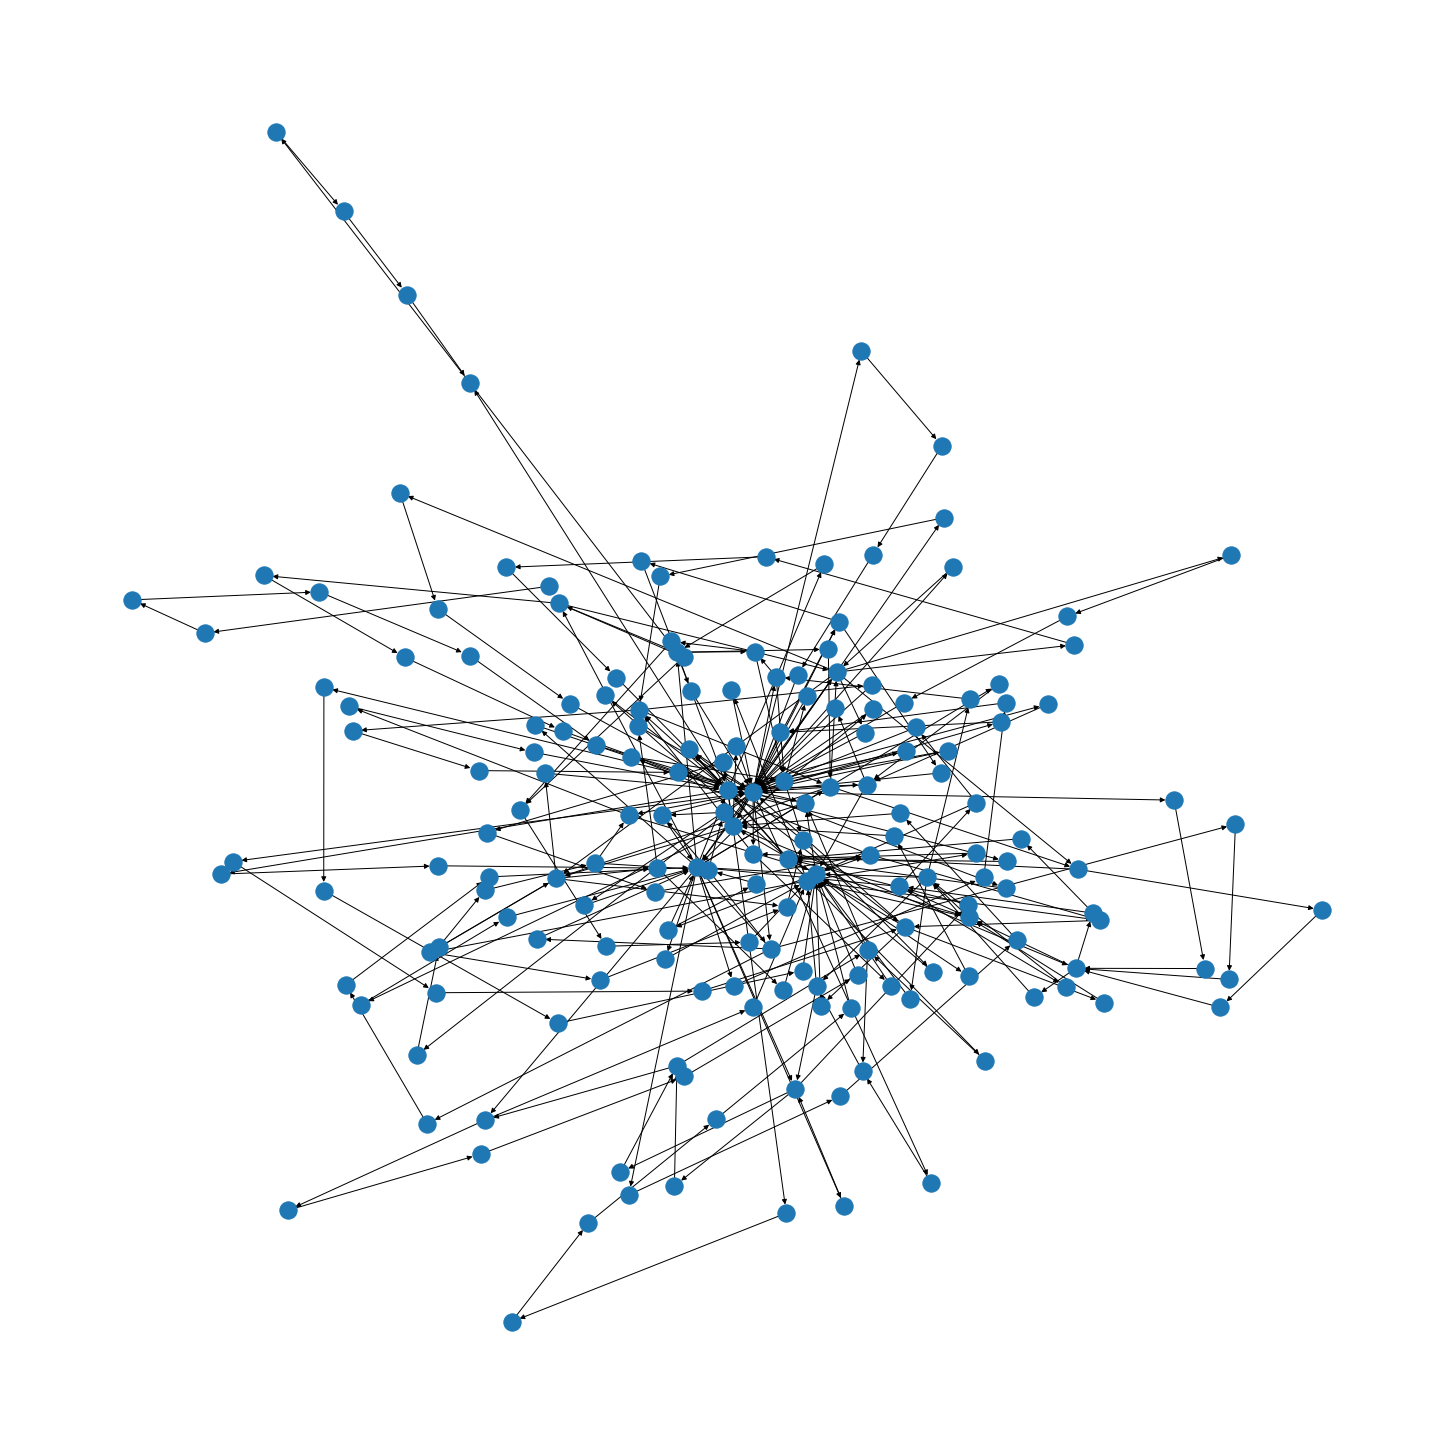

In [3]:
with open("data/data.txt","r") as f:
    data = f.readlines()
full_data = {}
title = None
word_pos = {}
for l in data:
    if l.startswith("#"):
        title = l.strip("#").strip("\n").strip()
        full_data[title]=[]
    else:
        if l!="\n":
            full_data[title].append([w for w,_ in pseg.lcut(l.strip("\n"))])
            for w,tag in pseg.lcut(l.strip("\n")):
                if title=="libra":
                    word_pos[w]=tag
data = full_data["libra"]
G =  nx.DiGraph()
for s in data:
    G.add_nodes_from(s)
    for i,w in enumerate(s[1:]):
        if (s[i],w) not in G.edges:
            G.add_edge(s[i],w,weight=1)
        else:
            G[s[i]][w]["weight"]+=1
plt.figure(figsize=(20,20))
nx.draw(G,with_label=True,font_weight="bold")
pd.Series(nx.pagerank(G)).sort_values(ascending=False)
left1 = {n:set() for n in G.nodes}
left2 = {n:set() for n in G.nodes}
right1 = {n:set() for n in G.nodes}
right2 = {n:set() for n in G.nodes}
for n in G.nodes:
    for l1 in G.predecessors(n):
        left1[n]|=set([l1])
        left2[n]|=set([l1])
        for l2 in G.predecessors(l1):
            left2[n]|=set([l2])
    for r1 in G.successors(n):
        right1[n]|=set([r1])
        right2[n]|=set([r1])
        for r2 in G.successors(r1):
            right2[n]|=set([r2])
context1 = {n:set() for n in G.nodes}
context2 = {n:set() for n in G.nodes}
for w in context1.keys():
    context1[w] = left1[w]|right1[w]
    context2[w] = left2[w]|right2[w]

In [4]:
set(list(G.nodes()))-set(word_pos.keys())

set()

# the words similarity are calculate with jacobian distance on the target word context, meaning words appear next two the target word.

In [5]:
similarity_matrix = pd.DataFrame(data=np.zeros((len(context1.keys()),len(context1.keys()))),index=list(context1.keys()),columns=list(context1.keys()))
for row in similarity_matrix.index:
    for col in similarity_matrix.columns:
        if row!=col:
            similarity_matrix.loc[row,col]=len(context1[row]&context1[col])/len(context1[row]|context1[col])
print("below are the found similar words with window size 1, left1 and right1")
for i,row in enumerate(similarity_matrix.index):
    for j,col in enumerate(similarity_matrix.columns):
        if i>j:
            if similarity_matrix.loc[row,col]>0.5:
                print(row,col,similarity_matrix.loc[row,col])

below are the found similar words with window size 1, left1 and right1
日内瓦 瑞士 1.0
阻止 要求 1.0
都 上线 1.0
管制 数字 1.0
提问 事实 1.0
称 表示 1.0


In [6]:
similarity_matrix = pd.DataFrame(data=np.zeros((len(context2.keys()),len(context2.keys()))),index=list(context2.keys()),columns=list(context2.keys()))
for row in similarity_matrix.index:
    for col in similarity_matrix.columns:
        if row!=col:
            similarity_matrix.loc[row,col]=len(context2[row]&context2[col])/len(context2[row]|context2[col])
print("below are the found similar words with window size 2, left2 and right2")
for i,row in enumerate(similarity_matrix.index):
    for j,col in enumerate(similarity_matrix.columns):
        if i>j:
            if similarity_matrix.loc[row,col]>0.9:
                print(row,col,similarity_matrix.loc[row,col])

below are the found similar words with window size 2, left2 and right2
日内瓦 瑞士 1.0
提问 事实 1.0
称 表示 1.0
需要 据 0.9166666666666666
需要 今天 0.9166666666666666
需要 那么 0.9166666666666666
需要 但 0.9166666666666666
需要 对 0.9166666666666666
现在 需要 0.9166666666666666
透露 日讯 0.9090909090909091
透露 报道 0.9090909090909091
透露 中 0.9090909090909091
透露 强调 0.9523809523809523
透露 上线 0.9090909090909091
透露 时 0.9090909090909091
手续费 透露 0.9090909090909091
具体 需要 0.9166666666666666


# node2vec is the graph equivalent of word2vec. The difference is that I run the algorithm on the same word context graph as the above wordrep.

In [7]:
node2vec = Node2Vec(G, dimensions=32, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 181/181 [00:00<00:00, 22366.00it/s]


In [8]:
G.nodes

NodeView(('PingWest', '品玩', '7', '月', '18', '日讯', '，', '据', '新浪', '科技', '报道', '今天', '美国众议院', '金融服务', '委员会', '针对', 'Facebook', ' ', 'Libra', '举行', '听证会', '所', '担心', '的', '问题', '向', '项目', '负责人', '大卫', '·', '马库斯', '（', 'David', 'Marcus', '）', '发问', '。', '这', '也', '是', '面临', '第二场', '议员', '询问', '第三方', '钱包', '是否', '可以', '整合', '入', 'WhatsApp', '和', 'Messenger', '中', '没有', '正面', '回应', '一', '综合', '昨日', '与', '美国参议院', '证词', '可能', '无法', '“', '如果', '你们', '要', '支付宝', '微信', '支付', '竞争', '那么', '为何', '在', '瑞士', '注册', '？', '篮子', '货币', '挂钩', '”', '默认', '了', '将', '、', '事实', '同时', '再次', '强调', '日内瓦', '不是', '为了', '逃避', '美国', '监管', '表示', '证券', 'ETF', '它', '商品', '但', '我们', '希望', '工具', '不会', '主权', '行使主权', '职责', '显然', '更', '适合', '央行', '对于', '愿意', '遵守', '美国财政部', '制裁', '要求', '并', '阻止', '无论', '会', '上线', '都', '有', '其他', '网络', '出现', '对', '许多', '国家', '来说', '成为', '一种', '非常', '高质量', '数字', '众议院', '如何', '具有', '管制', '/', '地区', '运行', '提问', '称', '不同', '方法', 'Blaine', '发展', '成', '什么样', '金融', '或', '银行', '服务', '需要', '时', '加密', '

In [9]:
def compare_words(w1,w2,model=model):
    return cosine(model.wv.get_vector(w1),model.wv.get_vector(w2))
def get_top_similar_words(w,words,k=5,model=model):
    distances = []
    for tw in words:
        if tw!=w:
            distances.append([tw,compare_words(w,tw)])
    results = pd.DataFrame(data=distances,columns=["top_{}_words".format(k),"scores"])
    return results.sort_values(["scores"])[:k]

# as we can see the two location words come very close to each other.

In [10]:
compare_words("日内瓦","瑞士")

0.0027747154235839844

In [11]:
compare_words("日内瓦","瑞士")

0.0027747154235839844

# and the top5 words for 表示 makes some sense too

In [12]:
get_top_similar_words('表示',list(G.nodes))

,top_5_words,scores
146,称,0.015386
29,·,0.512939
53,中,0.545446
30,马库斯,0.577133
24,问题,0.593033


# gcn untrained
这一部分使用未训练的gcn来得到词嵌入。因为原文里边使用未训练的gcn在跆拳道俱乐部图上得到了已经开始聚合的图嵌入。所以这个地方我也想使用未训练的gcn来得到词嵌入。因为没有训练，所以对结果期待不高。

In [13]:
indeces = list(G.nodes)

In [191]:
def gcn_layer(dad,inputs,dims=50):
    """
    一个gcn层，提前算好的D*A*D（DAD）。
    """
    params = np.random.random(size=(dims,dims))
    outputs = dad.dot(inputs).dot(params)
    return outputs
def gcn_embed(n_gcn=2):
    """
    gcn模型，先计算了DAD。初始的输入为单位矩阵。
    """
    np.random.seed(0)
    adj = nx.adjacency_matrix(G,G.nodes()).toarray()
    adj = adj+np.eye(adj.shape[0])
    dad = adj.dot(np.diag(np.power(adj.sum(1),-0.5))).T.dot(np.diag(np.power(adj.sum(1),-0.5)))
    inputs = np.ones((dad.shape[0],50))
    for _ in range(n_gcn):
        inputs = gcn_layer(dad,inputs)
    return inputs
def get_gcn_embedding(n_gcn,indeces=indeces):
    """
    一个获取gcn词嵌入的帮助函数。
    """
    embeddings = gcn_embed(n_gcn)
    gcn_embeddings = {}
    for i,e in zip(indeces,embeddings):
        gcn_embeddings[i]=e
    return gcn_embeddings
def compare_words(w1,w2,embeddings):
    """
    一个就是余弦距离的帮助函数。
    """
    return (cosine(embeddings[w1],embeddings[w2])+1)/2
def get_top_similar_words(w,embeddings,k=5,reverse=False):
    """
    一个计算前多少个最相近词的帮助函数。
    """
    distances = []
    for tw in embeddings.keys():
        if tw!=w:
            distances.append([tw,compare_words(w,tw,embeddings)])
    results = pd.DataFrame(data=distances,columns=["top_{}_words".format(k),"scores"])
    if reverse:
        return results.sort_values(["scores"])[-k:]
    return results.sort_values(["scores"])[:k]

In [15]:
gcn_embeddings = get_gcn_embedding(5,indeces)

In [16]:
compare_words("表示","称",gcn_embeddings)

0.0

In [17]:
get_top_similar_words("表示",gcn_embeddings)

,top_5_words,scores
20,听证会,-2.220446e-16
30,马库斯,-2.220446e-16
34,）,-2.220446e-16
163,讨论,-2.220446e-16
139,如何,-2.220446e-16


# training gcn with jieba pos

## prepare data

In [18]:
outputs = [word_pos[w] for w in list(G.nodes())]
o2id = {o:i for i,o in enumerate(set(outputs))}
outputs = [o2id[o] for o in outputs]

In [103]:
F.dropout?

Signature: F.dropout(input, p=0.5, training=True, inplace=False)
Docstring:
During training, randomly zeroes some of the elements of the input
tensor with probability :attr:`p` using samples from a Bernoulli
distribution.

See :class:`~torch.nn.Dropout` for details.

Args:
    p: probability of an element to be zeroed. Default: 0.5
    training: apply dropout if is ``True``. Defualt: ``True``
    inplace: If set to ``True``, will do this operation in-place. Default: ``False``
File:      ~/anaconda3/envs/chatterbot_env/lib/python3.6/site-packages/torch/nn/functional.py
Type:      function


In [125]:
class GCN_EMBEDDER(nn.Module):
    def __init__(self,G,embedding_size,output_size,n_gcn):
        super(GCN_EMBEDDER,self).__init__()
        adj = nx.adjacency_matrix(G,G.nodes()).toarray()
        adj = adj+np.eye(adj.shape[0])
        adj = adj.dot(np.diag(np.power(adj.sum(1),-0.5))).T.dot(np.diag(np.power(adj.sum(1),-0.5)))
        self.adj = torch.FloatTensor(adj)
        self.gcn_params = [nn.Linear(embedding_size,embedding_size) for _ in range(n_gcn)]
        self.projection = nn.Linear(embedding_size,output_size)
        self.embedding_size = embedding_size
        self.relu = F.relu
        self.dropout = nn.Dropout(0.1)
        self.norm = nn.BatchNorm1d(embedding_size)
    
    def gcn_layer(self,inputs):
        return torch.matmul(self.adj,inputs)
    def embed(self,inputs):
        for l in self.gcn_params:
            inputs = self.norm(self.relu(self.gcn_layer(inputs)))
        return inputs
    def forward(self,inputs):
        out = self.embed(inputs)
        out = self.relu(self.projection(out))
        log_probs = F.log_softmax(out,dim=1)
        return log_probs

In [94]:
def train_gcn_embedder(n_gcn=2,epochs=10):
    gcn_embedder = GCN_EMBEDDER(G,50,len(set(outputs)),n_gcn)
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gcn_embedder.parameters(),lr=0.001)
    
    for e in range(epochs):
        inputs = torch.ones(len(outputs),gcn_embedder.embedding_size)
        out = gcn_embedder(inputs)
        loss = loss_function(out,torch.LongTensor(outputs))
        losses.append(float(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gcn_embeddings = {}
    for i,e in zip(indeces,gcn_embedder.embed(torch.ones(len(outputs),gcn_embedder.embedding_size)).data.numpy()):
        gcn_embeddings[i]=e
    return gcn_embeddings,losses,gcn_embedder

In [21]:
gcn_embeddings,losses,gcn_embedder = train_gcn_embedder(epochs=30)

epoch 0 has loss 3.05
epoch 1 has loss 3.01
epoch 2 has loss 2.97
epoch 3 has loss 2.94
epoch 4 has loss 2.91
epoch 5 has loss 2.88
epoch 6 has loss 2.86
epoch 7 has loss 2.83
epoch 8 has loss 2.81
epoch 9 has loss 2.79
epoch 10 has loss 2.77
epoch 11 has loss 2.75
epoch 12 has loss 2.73
epoch 13 has loss 2.72
epoch 14 has loss 2.70
epoch 15 has loss 2.69
epoch 16 has loss 2.68
epoch 17 has loss 2.67
epoch 18 has loss 2.66
epoch 19 has loss 2.66
epoch 20 has loss 2.65
epoch 21 has loss 2.65
epoch 22 has loss 2.65
epoch 23 has loss 2.64
epoch 24 has loss 2.64
epoch 25 has loss 2.64
epoch 26 has loss 2.64
epoch 27 has loss 2.64
epoch 28 has loss 2.64
epoch 29 has loss 2.64


In [22]:
compare_words("表示","称",gcn_embeddings)

5.960464477539063e-08

In [23]:
get_top_similar_words("表示",gcn_embeddings,k=5,reverse=True)

,top_5_words,scores
171,为,1.788139e-07
134,一种,1.788139e-07
27,负责人,1.788139e-07
174,少量,1.788139e-07
151,成,1.788139e-07


In [24]:
gcn_embedder.adj.diag()

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.0357, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.2500, 0.2500, 0.2500, 0.3333, 0.1429, 0.1667,
        0.0588, 0.5000, 0.2500, 0.5000, 0.5000, 0.0769, 0.2000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.0909, 0.2000, 0.5000, 0.5000, 0.2000, 0.5000,
        0.1000, 0.3333, 0.5000, 0.2500, 0.5000, 0.5000, 0.2000, 0.2500, 0.3333,
        0.2000, 0.2500, 0.5000, 0.3333, 0.3333, 0.3333, 0.1429, 0.3333, 0.5000,
        0.5000, 0.5000, 0.5000, 0.3333, 0.5000, 0.5000, 0.2000, 0.5000, 0.5000,
        0.3333, 0.5000, 0.1667, 0.5000, 0.5000, 0.2500, 0.3333, 0.3333, 0.2500,
        0.2500, 0.5000, 0.3333, 0.2500, 0.5000, 0.3333, 0.3333, 0.5000, 0.1667,
        0.5000, 0.3333, 0.5000, 0.5000, 0.2000, 0.5000, 0.5000, 0.3333, 0.5000,
        0.5000, 0.5000, 0.3333, 0.5000, 0.5000, 0.5000, 0.5000, 0.2000, 0.5000,
        0.5000, 0.3333, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 

In [25]:
nx.adj_matrix(G,weight=None).toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [26]:
nx.adj_matrix(G,weight=None)

<181x181 sparse matrix of type '<class 'numpy.int64'>'
	with 301 stored elements in Compressed Sparse Row format>

In [27]:
indeces = list(G.nodes)
gcn_embeddings = {}
for i,e in zip(indeces,gcn_embedder.adj.data.numpy()):
    gcn_embeddings[i]=e

In [28]:
compare_words("表示","称",gcn_embeddings)

0.6322373449802399

In [29]:
get_top_similar_words("日内瓦",gcn_embeddings,k=5)

,top_5_words,scores
77,注册,0.500000
140,具有,0.666667
76,瑞士,0.666667
75,在,0.719458
0,PingWest,1.000000


In [30]:
context1

{'PingWest': {'品玩'},
 '品玩': {'7', 'PingWest'},
 '7': {'品玩', '月'},
 '月': {'18', '7'},
 '18': {'日讯', '月'},
 '日讯': {'18', '，'},
 '，': {'ETF',
  'Libra',
  '“',
  '上线',
  '不同',
  '中',
  '事实',
  '今天',
  '会',
  '但',
  '具体',
  '合作',
  '同时',
  '听证会',
  '商品',
  '它',
  '对',
  '强调',
  '手续费',
  '报道',
  '据',
  '提问',
  '日讯',
  '时',
  '来说',
  '现在',
  '称',
  '竞争',
  '第三方',
  '行使主权',
  '表示',
  '证词',
  '询问',
  '透露',
  '那么',
  '都',
  '针对',
  '问题',
  '需要',
  '马库斯'},
 '据': {'新浪', '，'},
 '新浪': {'据', '科技'},
 '科技': {'报道', '新浪'},
 '报道': {'科技', '，'},
 '今天': {'美国众议院', '，'},
 '美国众议院': {'今天', '金融服务'},
 '金融服务': {'委员会', '美国众议院'},
 '委员会': {'议员', '金融服务', '针对'},
 '针对': {'Facebook', '委员会', '所', '，'},
 'Facebook': {' ', '向', '和', '针对', '（', '）'},
 ' ': {'David', 'Facebook', 'Libra', 'Marcus', 'Messenger'},
 'Libra': {' ',
  '“',
  '。',
  '不会',
  '不是',
  '举行',
  '了',
  '会',
  '兑换',
  '在',
  '如何',
  '对于',
  '将',
  '把',
  '无论',
  '是',
  '是否',
  '的',
  '第三方',
  '询问',
  '钱包',
  '面临',
  '项目',
  '，'},
 '举行': {'Libra', '听证会'},
 

# training gcn on a skip-gram setting

In [39]:
words = list(set(sum(data,[])))
word2id = {w:i for i,w in enumerate(words)}
id2word = {i:w for i,w in enumerate(words)}

In [48]:
context1_ids = {}
for k in context1.keys():
    context1_ids[k] = [word2id[w] for w in context1[k]]
def spit_context(w,contexts):
    return np.random.choice(contexts["品玩"])

In [183]:
def train_gcn_embedder(vocab_size,n_gcn=2,epochs=10,batchs=3):
    np.random.seed(0)
    gcn_embedder = GCN_EMBEDDER(G,300,vocab_size,n_gcn)
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gcn_embedder.parameters(),lr=0.001)
    nodes = list(G.nodes())
    for e in range(epochs):
        for b in range(batchs):
            outputs = [spit_context(w,context1_ids) for w in nodes]
            inputs = torch.ones(len(outputs),gcn_embedder.embedding_size)
            gcn_embedder.zero_grad()
            out = gcn_embedder(inputs)
            loss = loss_function(out,torch.LongTensor(outputs))
            losses.append(float(loss.data.numpy()))
            loss.backward()
            optimizer.step()
        print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gcn_embeddings = {}
    for i,e in zip(indeces,gcn_embedder(torch.ones(len(outputs),gcn_embedder.embedding_size)).data.numpy()):
        gcn_embeddings[i]=e
    pd.Series(losses).plot();
    return gcn_embeddings,losses,gcn_embedder

epoch 0 has loss 5.11
epoch 1 has loss 4.98
epoch 2 has loss 4.87
epoch 3 has loss 4.82
epoch 4 has loss 4.67
epoch 5 has loss 4.61
epoch 6 has loss 4.45
epoch 7 has loss 4.61
epoch 8 has loss 4.36
epoch 9 has loss 4.52
epoch 10 has loss 4.51
epoch 11 has loss 4.26
epoch 12 has loss 3.91
epoch 13 has loss 3.93
epoch 14 has loss 3.86
epoch 15 has loss 3.94
epoch 16 has loss 3.95
epoch 17 has loss 3.75
epoch 18 has loss 3.75
epoch 19 has loss 4.16
epoch 20 has loss 3.62
epoch 21 has loss 3.60
epoch 22 has loss 3.73
epoch 23 has loss 3.75
epoch 24 has loss 3.68
epoch 25 has loss 3.51
epoch 26 has loss 3.21
epoch 27 has loss 3.48
epoch 28 has loss 3.25
epoch 29 has loss 3.51
epoch 30 has loss 3.28
epoch 31 has loss 2.97
epoch 32 has loss 2.95
epoch 33 has loss 2.69
epoch 34 has loss 2.46
epoch 35 has loss 2.45
epoch 36 has loss 2.44
epoch 37 has loss 2.25
epoch 38 has loss 2.22
epoch 39 has loss 2.08
epoch 40 has loss 1.99
epoch 41 has loss 1.89
epoch 42 has loss 1.79
epoch 43 has loss 1.8

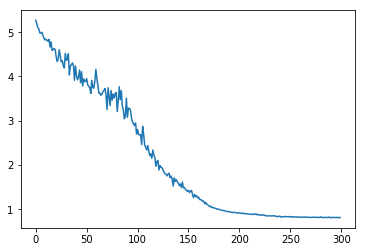

In [194]:
gcn_embeddings,losses,gcn_embedder = train_gcn_embedder(epochs=100,vocab_size=len(nodes))

In [195]:
compare_words("表示","称",gcn_embeddings)

0.5000012516975403

In [196]:
get_top_similar_words("表示",gcn_embeddings,k=155)

,top_155_words,scores
125,有,0.500000
92,不是,0.500000
62,证词,0.500000
132,来说,0.500000
87,事实,0.500000
85,将,0.500000
137,数字,0.500000
142,/,0.500000
161,合作,0.500000
108,职责,0.500000
